In [1]:
import pandas
import pycolmap
import os
import cv2
import numpy as np
import open3d as o3d
import logging
import pandas as pd
from logging import info, debug, warn, error

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
IMAGES_PATH = "../data/alameda/images"
COLMAP_PATH = "../data/alameda/colmap/sparse/0"
reconstruction = pycolmap.Reconstruction(COLMAP_PATH)
print(reconstruction.summary())
info(f"Loaded reconstruction")

INFO:root:Loaded reconstruction


Reconstruction:
	num_reg_images = 1734
	num_cameras = 1
	num_points3D = 347315
	num_observations = 2573099
	mean_track_length = 7.40855
	mean_observations_per_image = 1483.91
	mean_reprojection_error = 0.559822


In [4]:
points = np.array([point.xyz for point in reconstruction.points3D.values()])
colors = np.array([point.color for point in reconstruction.points3D.values()]) / 255  # Normalize RGB

In [5]:
#!export LIBGL_DRIVERS_PATH=/usr/lib/x86_64-linux-gnu/dri
#df = pd.DataFrame(colors)
#df

In [6]:
# Create point cloud
#point_cloud = o3d.geometry.PointCloud()
#point_cloud.points = o3d.utility.Vector3dVector(points)
#point_cloud.colors = o3d.utility.Vector3dVector(colors)

# Visualize
#o3d.visualization.draw_geometries([point_cloud])

In [7]:
import numpy as np
import cv2
import os

def project_to_img(reconstruction, image, cam_from_world, use_track=True, use_color=True, color_tolerance=0.05):
    # Camera parameters
    camera = reconstruction.cameras[image.camera_id]
    K = np.array([
        [camera.focal_length_x, 0, camera.principal_point_x],
        [0, camera.focal_length_y, camera.principal_point_y],
        [0, 0, 1]
    ])

    # Rotation and translation
    extrinsic_matrix = cam_from_world.matrix()
    R_matrix = extrinsic_matrix[:, :3]
    T = extrinsic_matrix[:, 3]
    # Convert rotation matrix to rotation vector
    R = cv2.Rodrigues(R_matrix)[0]

    # Prepare lists to store points and colors
    points3D = []
    model_colors = []

    # Collect points based on track or all points, depending on `use_track`
    if use_track:
        for point_id, point in reconstruction.points3D.items():
            if any(element.image_id == image.image_id for element in point.track.elements):
                points3D.append(point.xyz)
                model_colors.append(point.color / 255.)  # Normalize color values to [0, 1]
    else:
        points3D = [point.xyz for point in reconstruction.points3D.values()]
        model_colors = [point.color / 255. for point in reconstruction.points3D.values()]  # Normalize colors
    
    points3D = np.array(points3D)
    model_colors = np.array(model_colors)

    # Handle cases with no visible points
    if points3D.size == 0:
        return np.empty((0, 2))

    # Project 3D points to 2D image plane
    points2D = cv2.projectPoints(points3D, R, T, K, None)[0]
    
    # Load image and get its dimensions
    image_path = os.path.join(IMAGES_PATH, image.name)
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    # Only keep points within the image boundaries
    points2D_in_bounds = []
    colors_in_bounds = []
    for i, point in enumerate(points2D):
        x, y = int(point[0][0]), int(point[0][1])
        if 0 <= x < width and 0 <= y < height:
            points2D_in_bounds.append(point)
            colors_in_bounds.append(model_colors[i])  # Keep corresponding model color

    points2D_in_bounds = np.array(points2D_in_bounds)
    colors_in_bounds = np.array(colors_in_bounds)

    # Color filtering based on pixel difference
    if use_color:
        # Get the image colors at projected points' locations
        projected_colors = np.array([img[int(pt[0][1]), int(pt[0][0])] for pt in points2D_in_bounds]) / 255.
        
        # Calculate color differences
        color_diff = np.linalg.norm(projected_colors - colors_in_bounds, axis=1)
        
        # Logical OR condition: Include points with matching color or in the track
        if use_track:
            is_in_track = np.array([
                any(element.image_id == image.image_id for element in reconstruction.points3D[point_id].track.elements)
                for point_id in range(len(points2D_in_bounds))
            ])
            # Apply the OR condition between color match and track inclusion
            valid_points = (color_diff <= color_tolerance) | is_in_track
            filtered_points2D = points2D_in_bounds[valid_points]
        else:
            # Only filter based on color tolerance
            filtered_points2D = points2D_in_bounds[color_diff <= color_tolerance]
    else:
        # If color filtering is not used, return all points within bounds
        filtered_points2D = points2D_in_bounds

    return filtered_points2D


In [8]:
def density_map(points2D, image_shape, sigma=10):
    """
    Create a density map from projected 2D points with Gaussian smoothing.
    
    Args:
        points2D (np.ndarray): Array of 2D points (N, 1, 2) format from cv2.projectPoints.
        image_shape (tuple): Shape of the density map (height, width).
        sigma (int): Standard deviation for Gaussian blur.
        
    Returns:
        np.ndarray: Smoothed density map.
    """
    height, width = image_shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    # Populate the density map with the projected points
    for point in points2D:
        x, y = int(point[0][0]), int(point[0][1])
        if 0 <= x < width and 0 <= y < height:
            density_map[y, x] += 1 

    # Apply Gaussian blur using OpenCV
    ksize = int(6 * sigma + 1)
    smoothed_density_map = cv2.GaussianBlur(density_map, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    return smoothed_density_map

In [9]:
import numpy as np
import cv2
import os

def project_to_img(reconstruction, image, cam_from_world, use_track=True, use_color=True, color_tolerance=0.05):
    # Camera parameters
    camera = reconstruction.cameras[image.camera_id]
    K = np.array([
        [camera.focal_length_x, 0, camera.principal_point_x],
        [0, camera.focal_length_y, camera.principal_point_y],
        [0, 0, 1]
    ])

    # Rotation and translation
    extrinsic_matrix = cam_from_world.matrix()
    R_matrix = extrinsic_matrix[:, :3]
    T = extrinsic_matrix[:, 3]
    # Convert rotation matrix to rotation vector
    R = cv2.Rodrigues(R_matrix)[0]

    # Collect all 3D points and colors, independent of `use_track`
    points3D = [point.xyz for point in reconstruction.points3D.values()]
    model_colors = [point.color / 255. for point in reconstruction.points3D.values()]  # Normalize color values to [0, 1]
    point_ids = list(reconstruction.points3D.keys())  # Keep track of point IDs for track checking

    points3D = np.array(points3D)
    model_colors = np.array(model_colors)

    # Handle cases with no visible points
    if points3D.size == 0:
        return np.empty((0, 2))

    # Project 3D points to 2D image plane
    points2D = cv2.projectPoints(points3D, R, T, K, None)[0]
    
    # Load image and get its dimensions
    image_path = os.path.join(IMAGES_PATH, image.name)
    img = cv2.imread(image_path)
    height, width = img.shape[:2]

    # Only keep points within the image boundaries
    points2D_in_bounds = []
    colors_in_bounds = []
    in_bounds_point_ids = []  # Track the in-bounds point IDs for each point

    for i, point in enumerate(points2D):
        x, y = int(point[0][0]), int(point[0][1])
        if 0 <= x < width and 0 <= y < height:
            points2D_in_bounds.append(point)
            colors_in_bounds.append(model_colors[i])
            in_bounds_point_ids.append(point_ids[i])

    points2D_in_bounds = np.array(points2D_in_bounds)
    colors_in_bounds = np.array(colors_in_bounds)

    # Apply track and color filtering based on flags
    if use_color:
        # Get the image colors at projected points' locations
        projected_colors = np.array([img[int(pt[0][1]), int(pt[0][0])] for pt in points2D_in_bounds]) / 255.
        
        # Calculate color differences
        color_diff = np.linalg.norm(projected_colors - colors_in_bounds, axis=1)
        
        # Logical OR condition: Include points with matching color or in the track
        if use_track:
            # Check track membership
            is_in_track = np.array([
                any(element.image_id == image.image_id for element in reconstruction.points3D[pid].track.elements)
                for pid in in_bounds_point_ids
            ])
            # Apply the OR condition between color match and track inclusion
            valid_points = (color_diff <= color_tolerance) | is_in_track
            filtered_points2D = points2D_in_bounds[valid_points]
        else:
            # Only filter based on color tolerance
            filtered_points2D = points2D_in_bounds[color_diff <= color_tolerance]
    elif use_track:
        # Only apply track filtering with no color filtering
        is_in_track = np.array([
            any(element.image_id == image.image_id for element in reconstruction.points3D[pid].track.elements)
            for pid in in_bounds_point_ids
        ])
        filtered_points2D = points2D_in_bounds[is_in_track]
    else:
        # If neither color nor track filtering is used, return all points within bounds
        filtered_points2D = points2D_in_bounds

    return filtered_points2D


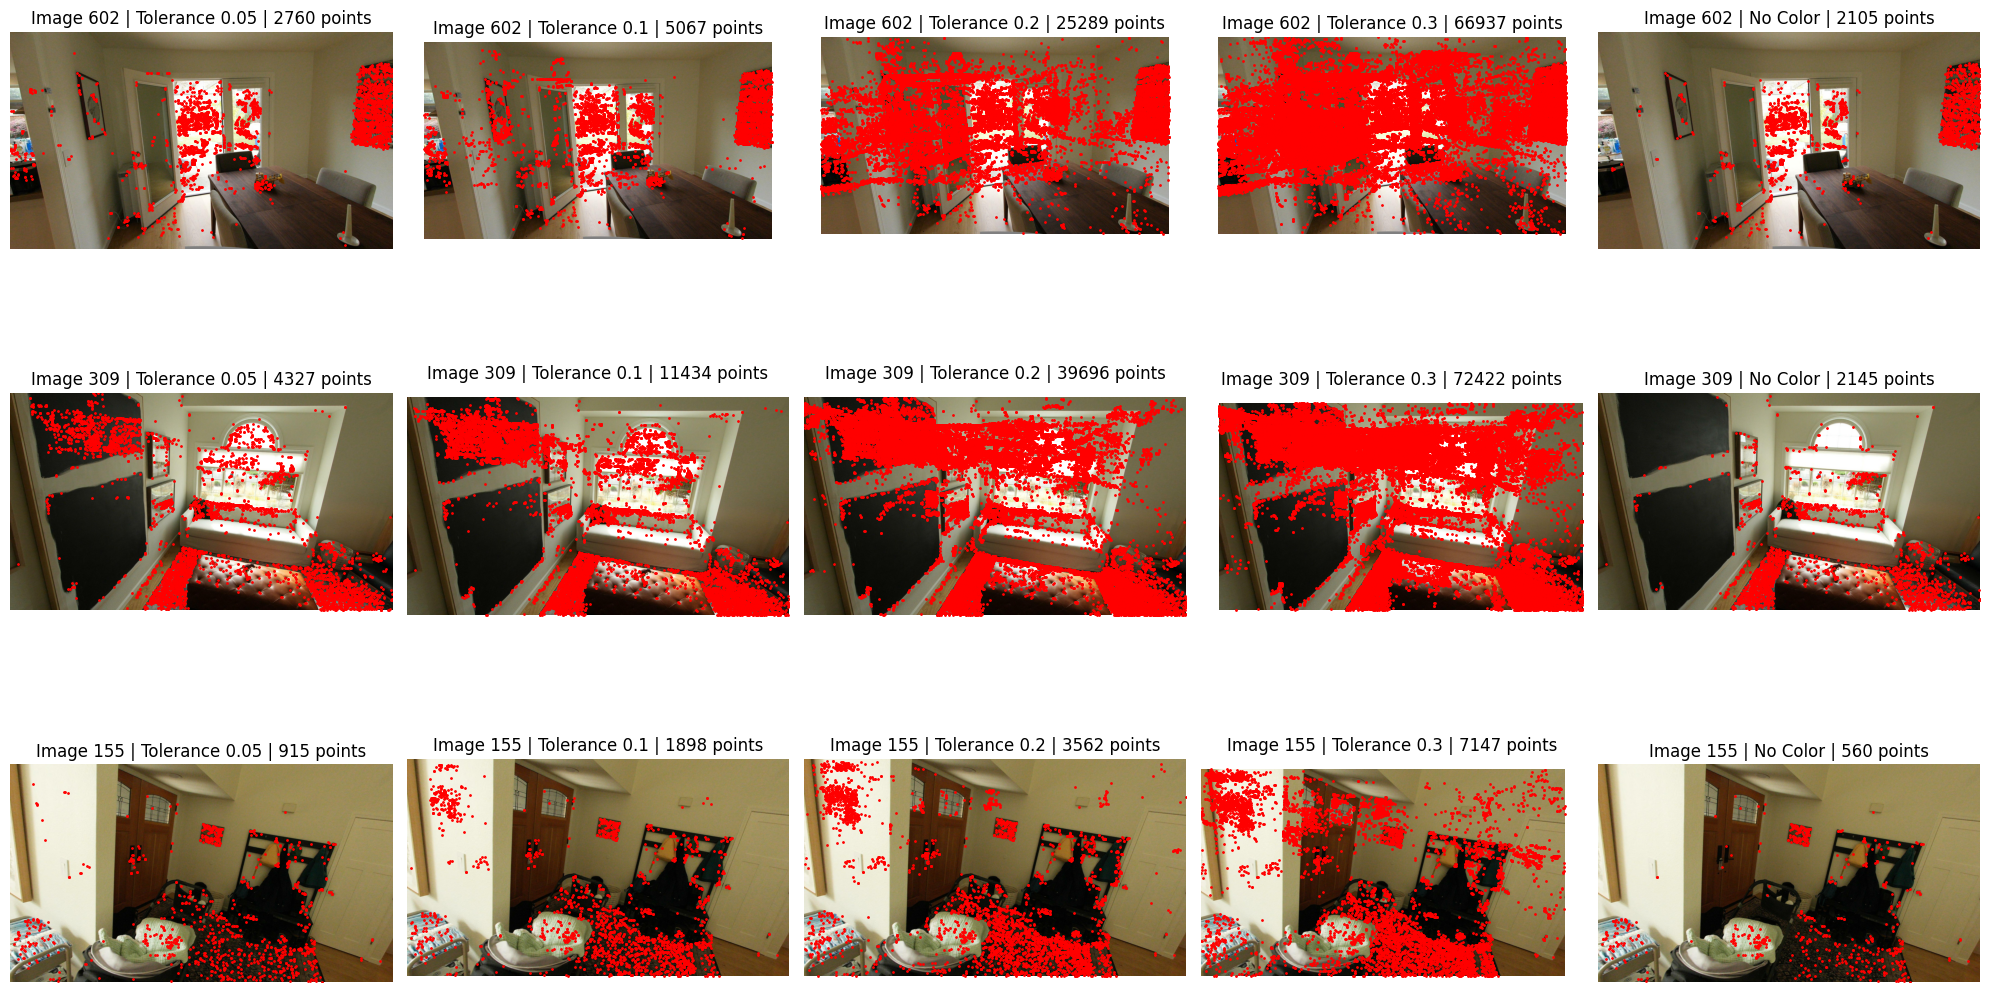

In [10]:
import random
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Define color tolerance values to test
color_tolerances = [0.05, 0.1, 0.2, 0.3]

# Select three random images to demonstrate the effect of color tolerance
random_images = random.sample(list(reconstruction.images.values()), 3)

# Create a figure with subplots (3 rows, 5 columns) for 3 images and different settings
fig, axes = plt.subplots(len(random_images), len(color_tolerances) + 1, figsize=(20, 12))

# Iterate over images and color tolerances
for row, image in enumerate(random_images):
    for col, color_tolerance in enumerate(color_tolerances):
        # Project 3D points to 2D for this image with the current color tolerance
        points2D = project_to_img(reconstruction, image, image.cam_from_world, use_color=True, color_tolerance=color_tolerance)
        
        # Load the original image
        original = cv2.imread(os.path.join(IMAGES_PATH, image.name))
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Display the original image with projected points for the current color tolerance
        ax_img = axes[row, col]
        ax_img.imshow(original_rgb)
        if points2D.size > 0:
            ax_img.scatter(points2D[:, 0, 0], points2D[:, 0, 1], c='r', s=1)  # Overlay points
        ax_img.set_title(f"Image {image.image_id} | Tolerance {color_tolerance} | {points2D.shape[0]} points")
        ax_img.axis('off')

    # Project with use_color=False, use_track=True for comparison
    points2D_no_color = project_to_img(reconstruction, image, image.cam_from_world, use_color=False, use_track=True)
    
    # Display the original image with projected points for the no color case
    ax_img_no_color = axes[row, len(color_tolerances)]
    ax_img_no_color.imshow(original_rgb)
    if points2D_no_color.size > 0:
        ax_img_no_color.scatter(points2D_no_color[:, 0, 0], points2D_no_color[:, 0, 1], c='r', s=1)  # Overlay points
    ax_img_no_color.set_title(f"Image {image.image_id} | No Color | {points2D_no_color.shape[0]} points")
    ax_img_no_color.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Statistics
import pandas as pd
import numpy as np
import random
import tqdm

# Define the density threshold
density_threshold = 0.5

# Prepare a list to store results
results = []

# Iterate over all training images
for image in tqdm.tqdm(reconstruction.images.values()):
    # Project 3D points onto the 2D image plane
    points2D = project_to_img(reconstruction, image, image.cam_from_world)
    
    # Load the original image to get its dimensions
    original = cv2.imread(os.path.join("../data/alameda/images", image.name))
    height, width = original.shape[:2]

    # Generate the density map for the projected points
    smoothed_density_map = density_map(points2D, (height, width), sigma=10)

    # Calculate the fraction of the image area with density above the threshold
    high_density_area = np.sum(smoothed_density_map > density_threshold)
    total_area = height * width
    fraction_high_density = high_density_area / total_area

    # Store the results for this image
    results.append({
        "image_id": image.image_id,
        "num_projected_points": points2D.shape[0],
        "fraction_high_density_area": fraction_high_density
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)
print(df)

# Save the DataFrame to a CSV file
df.to_csv("density_results.csv", index=False)


100%|██████████| 1734/1734 [1:21:50<00:00,  2.83s/it]

      image_id  num_projected_points  fraction_high_density_area
0         1691                  1474                         0.0
1           94                  1339                         0.0
2         1720                  4693                         0.0
3          123                  4986                         0.0
4          923                  2718                         0.0
...        ...                   ...                         ...
1729      1105                  3594                         0.0
1730      1106                  4034                         0.0
1731      1107                  3355                         0.0
1732      1108                  3424                         0.0
1733      1109                  2783                         0.0

[1734 rows x 3 columns]
